# Churn Analytics — Unified Workflow

This notebook walks through the **end-to-end pipeline** for a churn analytics learning project:

1. **Data Cleaning**  
2. **Feature Engineering**  
3. **Statistical Analysis & Insights**  
   - Chi-square tests (categorical vs churn)
   - t-test (watch hours between churned vs retained)
   - Correlation analysis
   - Visualisations (boxplot, bar charts, histogram)
4. **Predictive Modelling**  
   - Logistic Regression (classification — predict `is_churned`)
   - Linear Regression (regression — predict `average_watch_hours` or `tenure_days`)

> Inputs expected:  
> - `streamworks_user_data.csv` in the same working directory (raw)  
> - The notebook creates intermediate cleaned and engineered files for reuse.

### Installing Libraries

In [54]:
# === Setup & Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, mean_squared_error, r2_score)
from sklearn.feature_selection import VarianceThreshold

print("Libraries loaded.")


Libraries loaded.


## 1. Data Loading and 2. Data Cleaning

In [55]:
# Load raw
raw_path = Path('streamworks_user_data.csv')
assert raw_path.exists(), "streamworks_user_data.csv not found in the working directory."
df = pd.read_csv(raw_path, encoding='unicode_escape')

# 1) ID to string
df['user_id'] = df['user_id'].astype(str)

# 2) Age: fill then convert to Int64
df['age'] = df['age'].fillna(df['age'].median())
df['age'] = df['age'].astype('Int64')

# 3) Dates
df['signup_date'] = pd.to_datetime(df['signup_date'], format='mixed', dayfirst=True, errors='coerce')
df['last_active_date'] = pd.to_datetime(df['last_active_date'], format='mixed', dayfirst=True, errors='coerce')

# 4) Churn flag: convert and keep only {0,1}
df['is_churned'] = df['is_churned'].astype('Int64')
df = df[df['is_churned'].isin([0, 1])]

# 5) Categorical flags fill
df['received_promotions'] = df['received_promotions'].fillna('No')
df['referred_by_friend'] = df['referred_by_friend'].fillna('No')

# 6) Drop rows with missing key fields
df = df.dropna(subset=['user_id', 'is_churned'])

# 7) Gender handling
df['gender'] = df['gender'].fillna('Unspecified')
df['gender'] = df['gender'].astype(str).replace('Other', 'Unspecified')

# 8) Country + subscription type
df['country'] = df['country'].fillna('Unknown').astype(str).str.title()
df['subscription_type'] = df['subscription_type'].fillna('Unknown')

# 9) Date medians for missing values
signup_median = df['signup_date'].median()
df['signup_date'] = df['signup_date'].fillna(signup_median)

last_median = df['last_active_date'].median()
df['last_active_date'] = df['last_active_date'].fillna(last_median)

# 10) Numeric usage/fees
df['average_watch_hours'] = df['average_watch_hours'].fillna(df['average_watch_hours'].median())
df['mobile_app_usage_pct'] = df['mobile_app_usage_pct'].fillna(df['mobile_app_usage_pct'].median())
df['complaints_raised'] = df['complaints_raised'].fillna(0)
df['monthly_fee'] = df['monthly_fee'].fillna(df['monthly_fee'].median())

# 11) Categorical dtype
cat_cols = ['gender', 'country', 'subscription_type']
df[cat_cols] = df[cat_cols].astype('category')

# Save cleaned
clean_path = Path('streamworks_user_data.cleaned.csv')
df.to_csv(clean_path, index=False)

print("Cleaned shape:", df.shape)
df.head()


Cleaned shape: (1499, 14)


,user_id,age,gender,signup_date,last_active_date,country,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee
0,1001.0,56,Unspecified,2025-04-02,2025-07-13,France,Standard,42.6,77.4,1.0,No,No,1,10.99
1,1002.0,69,Male,2023-01-02,2025-07-13,India,Basic,65.3,98.0,4.0,No,Yes,1,5.99
2,1003.0,46,Male,2022-08-21,2025-07-13,Uk,Premium,40.1,47.8,0.0,No,Yes,1,13.99
3,1004.0,32,Unspecified,2023-09-14,2025-07-13,Germany,Premium,5.8,53.2,1.0,Yes,Yes,1,13.99
4,1005.0,60,Female,2023-07-29,2025-07-13,India,Standard,32.7,16.8,5.0,No,Yes,0,9.99


## 3. Feature Engineering

In [56]:
# 1. Tenure in days
df['tenure_days'] = (pd.to_datetime(df['last_active_date']) - pd.to_datetime(df['signup_date'])).dt.days

# 2. Loyalty flag
df['is_loyal'] = (df['tenure_days'] >= 365).astype(int)

# 3. Watch per fee ratio
df['watch_per_fee_ratio'] = df['average_watch_hours'] / df['monthly_fee'].replace(0, pd.NA)
df['watch_per_fee_ratio'] = df['watch_per_fee_ratio'].fillna(0)

# 4. Heavy mobile user flag
df['heavy_mobile_user'] = (df['mobile_app_usage_pct'] > 75).astype(int)

# 5. Age group binning
bins = [0, 25, 40, 60, 100]
labels = ['Young', 'Adult', 'Middle_Aged', 'Senior']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# 6. Log transform for skewed feature (complaints)
df['log_complaints'] = np.log1p(df['complaints_raised'])

# 7. Binary encoding for promotions and referral
binary_map = {'Yes': 1, 'No': 0}
df['received_promotions'] = df['received_promotions'].map(binary_map)
df['referred_by_friend'] = df['referred_by_friend'].map(binary_map)

# 8. Ordinal encoding for subscription type
subscription_map = {'Basic': 1, 'Standard': 2, 'Premium': 3, 'Unknown': 0}
df['subscription_type'] = df['subscription_type'].map(subscription_map)

# 9. Watch hours binning (optional)
bins_new = [0, 0.25, 0.5, 0.75, 1]
labels_new = ['Low', 'Medium', 'High', 'Very High']
# Create bin safely using normalized proxy if needed
# Here we directly bin raw watch hours if reasonable for your dataset distributions:
df['watch_hours_bin'] = pd.cut(df['average_watch_hours'], bins=bins_new, labels=labels_new, include_lowest=True)

# 10. Interaction feature: promo & low watch
median_watch = df['average_watch_hours'].median()
df['promo_low_watch'] = ((df['received_promotions'] == 1) & (df['average_watch_hours'] < median_watch)).astype(int)

# 11. One-hot encode categorical columns (drop_first=True)
cat_cols = ['gender', 'country', 'age_group', 'watch_hours_bin']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 12. Scaling numeric features (after encoding)
scaler = MinMaxScaler()
numeric_cols = ['age', 'average_watch_hours', 'monthly_fee', 'watch_per_fee_ratio', 'tenure_days']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 13. Variance threshold feature selection
selector = VarianceThreshold(threshold=0.01)
numeric_features = df.select_dtypes(include=['float64', 'int64', 'Int64']).columns
df[numeric_features] = selector.fit_transform(df[numeric_features])

# Save engineered
final_path = Path('streamworks_user_data_final.csv')
df.to_csv(final_path, index=False)

print("Final (engineered) shape:", df.shape)
df.head()



Final (engineered) shape: (1499, 32)


,user_id,age,signup_date,last_active_date,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,...,country_India,country_Uk,country_Unknown,country_Usa,age_group_Adult,age_group_Middle_Aged,age_group_Senior,watch_hours_bin_Medium,watch_hours_bin_High,watch_hours_bin_Very High
0,1001.0,0.745098,2025-04-02,2025-07-13,2,0.530227,77.4,1.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
1,1002.0,1.000000,2023-01-02,2025-07-13,1,0.816121,98.0,4.0,0.0,1.0,...,True,False,False,False,False,False,True,False,False,False
2,1003.0,0.549020,2022-08-21,2025-07-13,3,0.498741,47.8,0.0,0.0,1.0,...,False,True,False,False,False,True,False,False,False,False
3,1004.0,0.274510,2023-09-14,2025-07-13,3,0.066751,53.2,1.0,1.0,1.0,...,False,False,False,False,True,False,False,False,False,False
4,1005.0,0.823529,2023-07-29,2025-07-13,2,0.405542,16.8,5.0,0.0,1.0,...,True,False,False,False,False,True,False,False,False,False


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1499 entries, 0 to 1499
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   user_id                    1499 non-null   object        
 1   age                        1499 non-null   float64       
 2   signup_date                1499 non-null   datetime64[ns]
 3   last_active_date           1499 non-null   datetime64[ns]
 4   subscription_type          1499 non-null   category      
 5   average_watch_hours        1499 non-null   float64       
 6   mobile_app_usage_pct       1499 non-null   float64       
 7   complaints_raised          1499 non-null   float64       
 8   received_promotions        1499 non-null   float64       
 9   referred_by_friend         1499 non-null   float64       
 10  is_churned                 1499 non-null   float64       
 11  monthly_fee                1499 non-null   float64       
 12  tenure_days

## 4. Statistical Analysis & Insights

gender: Chi2=4.028, p-value=0.1334, dof=2
received_promotions: Chi2=2.569, p-value=0.1090, dof=1
referred_by_friend: Chi2=0.645, p-value=0.4218, dof=1

T-test on average_watch_hours: t=-0.179, p=0.8577

Correlation with churn:
 is_churned              1.000000
is_loyal                0.020308
mobile_app_usage_pct    0.016426
tenure_days             0.012913
age                     0.002229
watch_per_fee_ratio    -0.000628
average_watch_hours    -0.004672
log_complaints         -0.005288
complaints_raised      -0.005786
heavy_mobile_user      -0.010829
referred_by_friend     -0.022324
monthly_fee            -0.022714
received_promotions    -0.042975
promo_low_watch        -0.050706
Name: is_churned, dtype: float64


C:\Users\shabn\AppData\Local\Temp\ipykernel_77312\3752506078.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Retained (0)', 'Churned (1)'])


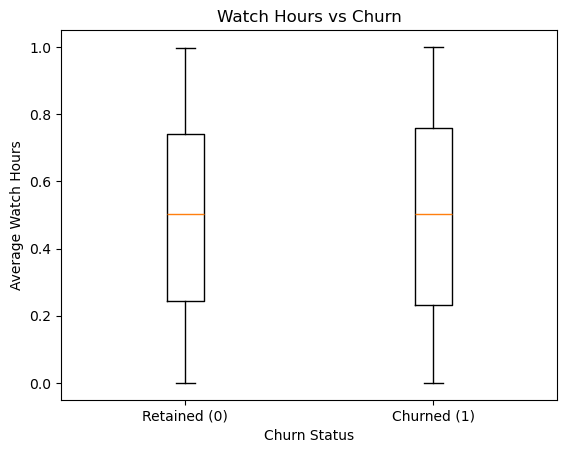

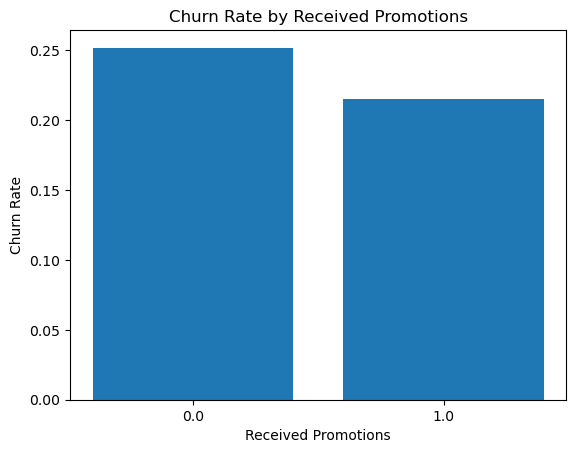

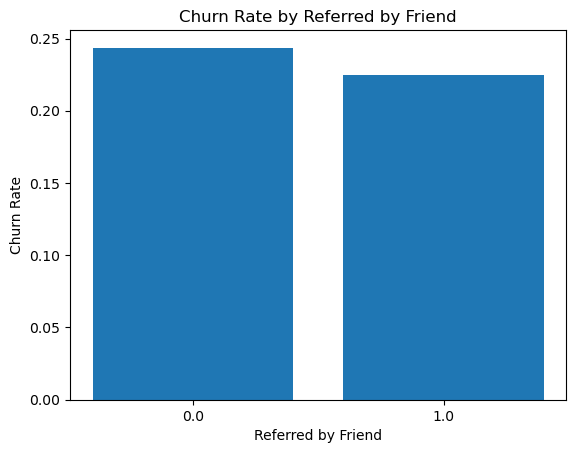

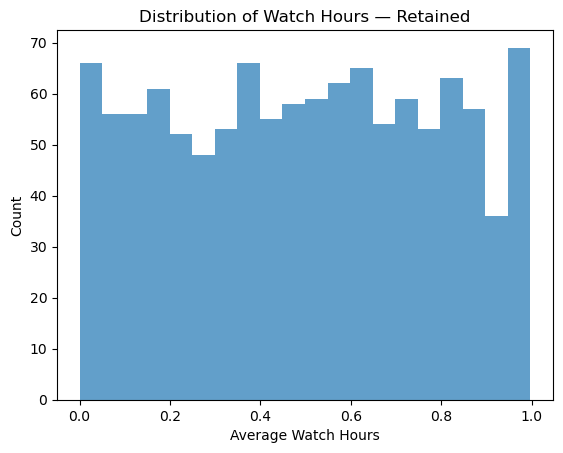

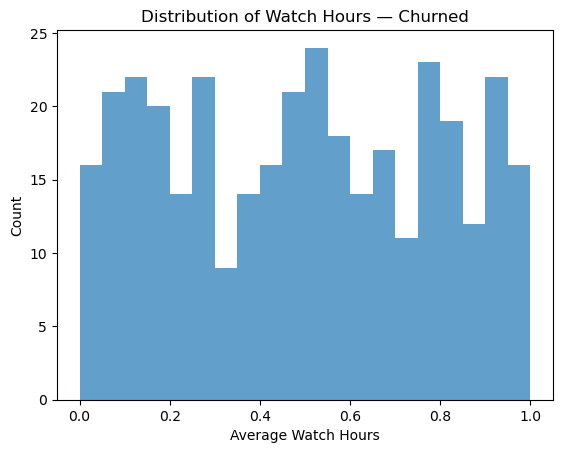

In [51]:
# --- 3.1 Chi-square tests ---
def chi_square_test(col):
    contingency = pd.crosstab(df[col], df['is_churned'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    return chi2, p, dof

for col in ['gender', 'received_promotions', 'referred_by_friend']:
    if col in df.columns:
        chi2, p, dof = chi_square_test(col)
        print(f"{col}: Chi2={chi2:.3f}, p-value={p:.4f}, dof={dof}")
    else:
        print(f"Warning: column '{col}' not found after encoding.")

# --- 3.2 T-test: watch hours between churned vs retained ---
churned_watch = df[df['is_churned'] == 1]['average_watch_hours']
retained_watch = df[df['is_churned'] == 0]['average_watch_hours']
t_stat, p_val = ttest_ind(churned_watch, retained_watch, equal_var=False, nan_policy='omit')
print(f"\nT-test on average_watch_hours: t={t_stat:.3f}, p={p_val:.4f}")

# --- 3.3 Correlation with churn ---
corr_with_churn = df.corr(numeric_only=True)['is_churned'].sort_values(ascending=False)
print("\nCorrelation with churn:\n", corr_with_churn.head(20))

# --- 3.4 Visualisations (matplotlib only) ---

# Boxplot: watch hours vs churn
plt.figure()
data0 = df[df['is_churned']==0]['average_watch_hours'].dropna().values
data1 = df[df['is_churned']==1]['average_watch_hours'].dropna().values
plt.boxplot([data0, data1], labels=['Retained (0)', 'Churned (1)'])
plt.title('Watch Hours vs Churn')
plt.xlabel('Churn Status')
plt.ylabel('Average Watch Hours')
plt.show()

# Bar chart: churn rate by promotions
plt.figure()
promo_vals = df.groupby('received_promotions')['is_churned'].mean()
plt.bar(promo_vals.index.astype(str), promo_vals.values)
plt.title('Churn Rate by Received Promotions')
plt.xlabel('Received Promotions')
plt.ylabel('Churn Rate')
plt.show()

# Bar chart: churn rate by referral
plt.figure()
ref_vals = df.groupby('referred_by_friend')['is_churned'].mean()
plt.bar(ref_vals.index.astype(str), ref_vals.values)
plt.title('Churn Rate by Referred by Friend')
plt.xlabel('Referred by Friend')
plt.ylabel('Churn Rate')
plt.show()

# Histogram: watch hours by churn status
plt.figure()
plt.hist(df[df['is_churned']==0]['average_watch_hours'].dropna(), bins=20, alpha=0.7)
plt.title('Distribution of Watch Hours — Retained')
plt.xlabel('Average Watch Hours')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(df[df['is_churned']==1]['average_watch_hours'].dropna(), bins=20, alpha=0.7)
plt.title('Distribution of Watch Hours — Churned')
plt.xlabel('Average Watch Hours')
plt.ylabel('Count')
plt.show()


In [ ]:
df.info()

## 4. Predictive Modelling — Logistic Regression (Binary Classification)

Confusion Matrix:
 [[345   0]
 [105   0]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       345
         1.0       0.00      0.00      0.00       105

    accuracy                           0.77       450
   macro avg       0.38      0.50      0.43       450
weighted avg       0.59      0.77      0.67       450

ROC AUC Score: 0.49976535541752937


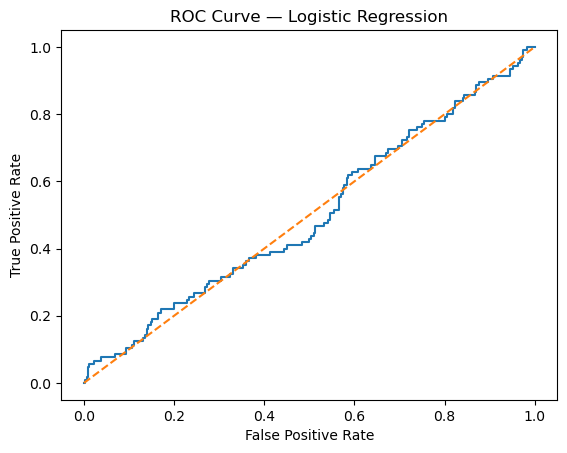


Top Predictors (by absolute coefficient):
                   Feature  Coefficient  AbsCoeff
9     watch_per_fee_ratio    -0.260151  0.260151
22  age_group_Middle_Aged     0.228879  0.228879
29    subscription_type_0    -0.204921  0.204921
23       age_group_Senior     0.204863  0.204863
19        country_Unknown    -0.196327  0.196327
1     average_watch_hours     0.179517  0.179517
8                is_loyal     0.161687  0.161687
11         log_complaints    -0.160978  0.160978
0                     age    -0.146751  0.146751
10      heavy_mobile_user    -0.145232  0.145232
2    mobile_app_usage_pct     0.134873  0.134873
14     gender_Unspecified    -0.119499  0.119499
12        promo_low_watch    -0.118860  0.118860
13            gender_Male    -0.116873  0.116873
27    subscription_type_3    -0.113967  0.113967


In [57]:
# Prepare features (convert bools and categories to numeric)
X = df.drop(columns=['user_id','signup_date', 'last_active_date', 'is_churned'])
X = X.copy()
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)
X = pd.get_dummies(X, drop_first=True)

y = df['is_churned']

# Handle missing values (median for numeric, most_frequent for categorical if needed)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_s, y_train)

# Predict
y_pred = log_reg.predict(X_test_s)
y_proba = log_reg.predict_proba(X_test_s)[:, 1]

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression')
plt.show()

# Coefficients
feature_names = X.columns
coefficients = log_reg.coef_[0]
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'AbsCoeff': np.abs(coefficients)
}).sort_values('AbsCoeff', ascending=False)

print("\nTop Predictors (by absolute coefficient):\n", coef_df.head(15))


## 5. Predictive Modelling — Linear Regression (Continuous Prediction)

R^2: 0.6737
RMSE: 0.1671


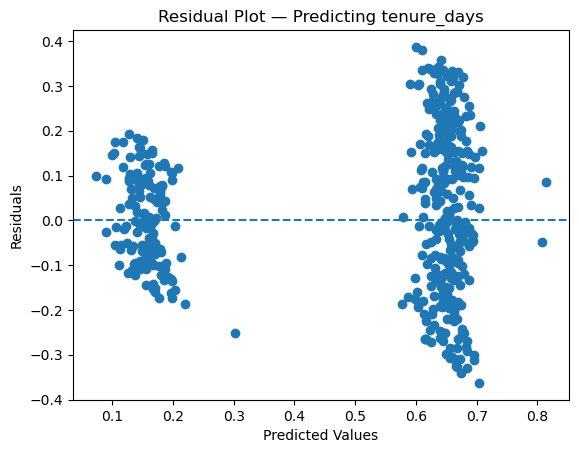


Top Coefficients:
                       Feature  Coefficient
7                    is_loyal     0.232803
26        subscription_type_3     0.031332
10             log_complaints     0.027309
8         watch_per_fee_ratio     0.019724
25  watch_hours_bin_Very High     0.011102
24       watch_hours_bin_High     0.010752
21      age_group_Middle_Aged     0.008161
27        subscription_type_2     0.004938
5          referred_by_friend     0.004935
4         received_promotions     0.004309
23     watch_hours_bin_Medium     0.003910
9           heavy_mobile_user     0.002397
28        subscription_type_0     0.001518
19                country_Usa     0.001120
17                 country_Uk     0.000517


In [35]:
# Prepare features & target
if target_column in df.columns:
    X = df.drop(columns=[target_column,'user_id', 'signup_date', 'last_active_date', 'is_churned'])
else:
    X = df.drop(columns=['user_id','signup_date', 'last_active_date', 'is_churned'])

y = df[target_column]

# Convert bool → int
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)

# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Model
lin_reg = LinearRegression()
lin_reg.fit(X_train_s, y_train)

# Predict
y_pred = lin_reg.predict(X_test_s)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Residual plot
residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residual Plot — Predicting {target_column}')
plt.show()

# Coefficients
feat_names = X.columns
coefs = lin_reg.coef_
coef_df = pd.DataFrame({'Feature': feat_names, 'Coefficient': coefs}).sort_values('Coefficient', ascending=False)
print("\nTop Coefficients:\n", coef_df.head(15))


Target: average_watch_hours
R^2: 0.8938
RMSE: 0.0927


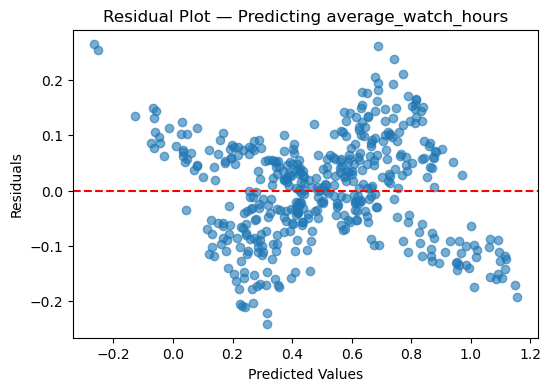


Top Positive Coefficients (increase target):
                 Feature  Coefficient
8   watch_per_fee_ratio     0.289063
5           monthly_fee     0.132425
27  subscription_type_2     0.028030
3   received_promotions     0.027168
10       log_complaints     0.016523

Top Negative Coefficients (decrease target):
                  Feature  Coefficient
6            tenure_days    -0.009326
22      age_group_Senior    -0.010524
24  watch_hours_bin_High    -0.010596
2      complaints_raised    -0.017289
11       promo_low_watch    -0.039961


In [42]:
# === Choose target ===
target_column = 'average_watch_hours'  # Change to any other numeric column you want to test

# === Prepare features & target ===
drop_cols = ['user_id','signup_date', 'last_active_date', 'is_churned']
if target_column in df.columns:
    drop_cols.append(target_column)

X = df.drop(columns=drop_cols)
y = df[target_column]

# Convert bool → int
X = X.copy()
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)

# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# === Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

# === Scale ===
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# === Model ===
lin_reg = LinearRegression()
lin_reg.fit(X_train_s, y_train)

# === Predict ===
y_pred = lin_reg.predict(X_test_s)

# === Metrics ===
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Target: {target_column}")
print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# === Residual plot ===
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residual Plot — Predicting {target_column}')
plt.show()

# === Coefficients ===
feature_names = X.columns
coefs = lin_reg.coef_
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs}) \
    .sort_values('Coefficient', ascending=False)

print("\nTop Positive Coefficients (increase target):\n", coef_df.head(5))
print("\nTop Negative Coefficients (decrease target):\n", coef_df.tail(5))

Target: tenure_days
R^2: 0.6737
RMSE: 0.1671


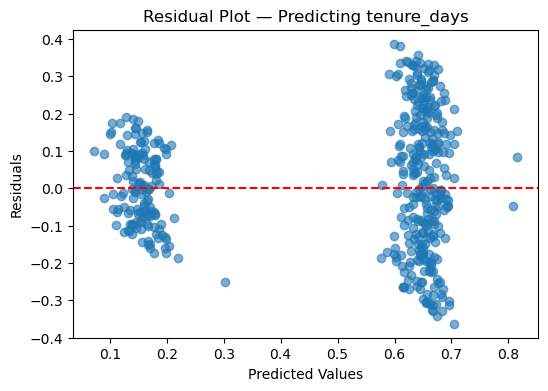


Top Positive Coefficients (increase target):
                       Feature  Coefficient
7                    is_loyal     0.232803
26        subscription_type_3     0.031332
10             log_complaints     0.027309
8         watch_per_fee_ratio     0.019724
25  watch_hours_bin_Very High     0.011102

Top Negative Coefficients (decrease target):
                 Feature  Coefficient
15      country_Germany    -0.005692
14       country_France    -0.010384
6           monthly_fee    -0.019365
3     complaints_raised    -0.031747
1   average_watch_hours    -0.032267


In [36]:
# === Choose target ===
target_column = 'tenure_days'  # Change to any other numeric column you want to test

# === Prepare features & target ===
drop_cols = ['user_id','signup_date', 'last_active_date', 'is_churned']
if target_column in df.columns:
    drop_cols.append(target_column)

X = df.drop(columns=drop_cols)
y = df[target_column]

# Convert bool → int
X = X.copy()
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)

# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# === Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

# === Scale ===
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# === Model ===
lin_reg = LinearRegression()
lin_reg.fit(X_train_s, y_train)

# === Predict ===
y_pred = lin_reg.predict(X_test_s)

# === Metrics ===
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Target: {target_column}")
print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# === Residual plot ===
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residual Plot — Predicting {target_column}')
plt.show()

# === Coefficients ===
feature_names = X.columns
coefs = lin_reg.coef_
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs}) \
    .sort_values('Coefficient', ascending=False)

print("\nTop Positive Coefficients (increase target):\n", coef_df.head(5))
print("\nTop Negative Coefficients (decrease target):\n", coef_df.tail(5))

# 6. Business Questions to Answer

In [58]:
#1. Do users who receive promotions churn less? 
promo_churn_rate = df.groupby('received_promotions')['is_churned'].mean()
print(promo_churn_rate)



received_promotions
0.0    0.251958
1.0    0.215553
Name: is_churned, dtype: float64


received_promotions
0.0    766
1.0    733
Name: count, dtype: int64
received_promotions
0.0    193
1.0    158
Name: count, dtype: int64
received_promotions
0.0    25.195822
1.0    21.555252
Name: count, dtype: float64


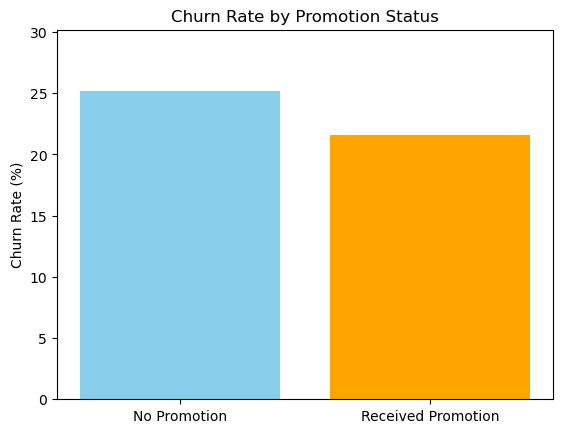

In [60]:
#1. Do users who receive promotions churn less? 
df_churn = df[df['is_churned'] == 1]

# Calculate total users per promotion status
total_users = df['received_promotions'].value_counts().sort_index()
print(total_users)
# Calculate churned users per promotion status (you already have this)
churned_users = df_churn['received_promotions'].value_counts().sort_index()
print(churned_users)
# Calculate churn rate = churned / total users per group
churn_rate = (churned_users / total_users) * 100  # percent churn rate
print(churn_rate)
# Map promotion status to labels
labels = ['No Promotion', 'Received Promotion']

plt.bar(labels, churn_rate, color=['skyblue', 'orange'])
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Promotion Status')
plt.ylim(0, max(churn_rate) + 5)  # a little padding on y-axis
plt.show()



In [59]:
#2. Does watch time impact churn likelihood?  

from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(
    df[df['is_churned'] == 1]['average_watch_hours'],
    df[df['is_churned'] == 0]['average_watch_hours'],
    equal_var=False
)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")

T-statistic: -0.179, p-value: 0.8577


In [39]:
#3. Are mobile dominant users more likely to cancel?  

mobile_churn_rate = df.groupby('heavy_mobile_user')['is_churned'].mean()
print(mobile_churn_rate)

heavy_mobile_user
0    0.236890
1    0.226463
Name: is_churned, dtype: float64


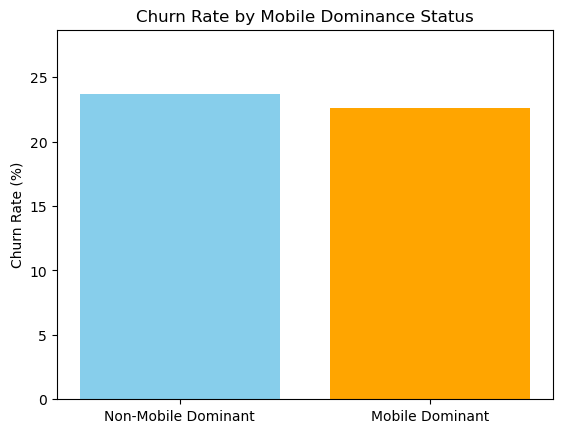

Churn rates (%):
heavy_mobile_user
0    23.688969
1    22.646310
Name: count, dtype: float64
Z-test statistic: 0.419
P-value: 0.675
The difference in churn rates is NOT statistically significant.


In [61]:
#3. Are mobile dominant users more likely to cancel?  

# Calculate churn counts by mobile dominance
churn_counts = df[df['is_churned'] == 1]['heavy_mobile_user'].value_counts().sort_index()

# Calculate total users by mobile dominance
total_counts = df['heavy_mobile_user'].value_counts().sort_index()

# Calculate churn rate (%)
churn_rate = (churn_counts / total_counts) * 100

# Labels for the plot
labels = ['Non-Mobile Dominant', 'Mobile Dominant']

plt.bar(labels, churn_rate, color=['skyblue', 'orange'])
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Mobile Dominance Status')
plt.ylim(0, max(churn_rate) + 5)
plt.show()

print("Churn rates (%):")
print(churn_rate)
#Step 2: Statistical test (two-proportion z-test)
#To test if the difference is significant:

from statsmodels.stats.proportion import proportions_ztest

# Number of churned users per group
count = churn_counts.values

# Number of total users per group
nobs = total_counts.values

# Perform two-proportion z-test
stat, pval = proportions_ztest(count, nobs)

print(f"Z-test statistic: {stat:.3f}")
print(f"P-value: {pval:.3f}")

if pval < 0.05:
    print("The difference in churn rates is statistically significant.")
else:
    print("The difference in churn rates is NOT statistically significant.")


In [ ]:
#4. What are the top 3 features influencing churn based on your model? 
coef_df = pd.DataFrame({ 
    'Feature' : X.columns,
    'Coefficient': log_reg.coef_[0]
})
coef_df['AbsCoeff'] = coef_df['Coefficient'].abs() 
top_features = coef_df.sort_values('AbsCoeff', ascending=False).head(3)
print(top_features)


In [40]:
coef_df.head(3)

,Feature,Coefficient
7,is_loyal,0.232803
26,subscription_type_3,0.031332
10,log_complaints,0.027309


In [ ]:
#5. Which customer segments should the retention team prioritise?  

In [41]:
#6. What factors affect user watch time or tenure? (Linear regression insight)
coef_df_watch = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lin_reg.coef_
}).sort_values('Coefficient', ascending=False)
print(coef_df_watch.head(5))

                      Feature  Coefficient
7                    is_loyal     0.232803
26        subscription_type_3     0.031332
10             log_complaints     0.027309
8         watch_per_fee_ratio     0.019724
25  watch_hours_bin_Very High     0.011102
